# plt

In [ ]:
#| default_exp repr_plt

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq, is_close

In [ ]:
# |export
# |hide

import math
from typing import Union
from matplotlib import pyplot as plt
from IPython.core.pylabtools import print_figure
import torch

from lovely_tensors.repr_str import lovely, pretty_str

In [ ]:
# |hide
# |exporti
def normal_pdf( x: torch.Tensor,
                mean: Union[torch.Tensor, float] =0.,
                std: Union[torch.Tensor, float] =1.):
    r"""Probability Distribution Function of Normal Distribution:
        $$f(x, \mu, \sigma)
        = \dfrac{1}
            {\sigma \sqrt{2\pi} }
        e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^{2}}
        = \dfrac{e^{- \frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}}
            {\sigma \sqrt{2\pi}}$$"""

    dev = x.device
    e = torch.tensor(math.e).to(dev)
    pi = torch.tensor(math.pi).to(dev)

    mean = torch.tensor(mean).to(dev) if not isinstance(mean, torch.Tensor) else mean
    std = torch.tensor(std).to(dev) if not isinstance(std, torch.Tensor) else std

    return (e
                .pow( -0.5 * ((x - mean)/std).pow(2) )
                .div((std * (pi * 2).sqrt()))
            )

In [ ]:
# |eval: false
import scipy
x = torch.arange(-4, 4, 0.01)
y1 = torch.tensor(scipy.stats.norm.pdf(x, 2, 3))
y2 = normal_pdf(x, 2, 3)

test_eq(is_close(y1, y2), True)

In [ ]:
# |exporti
@torch.no_grad()
def _plot(t: torch.Tensor, center="zero", max_s=100000, ax=None):
    """Plot tensor statistics"""

    assert center in ["zero", "mean", "range"]

    t_str = str(lovely(t, color=False))

    # Same as in `lovely()`, we have to move it to cpu before good-value indexing.
    cput = t.detach().cpu()
    del t
    t = cput

    # `t`` may have nasty things like 'nan' and 'inf'. Could also be of non-float type.
    t = t[ torch.isfinite(t) ].float()

    t_min, t_max = t.min().item(), t.max().item()
    t_mean, t_std = t.mean().item(), t.std().item()
    
    # `t` might be not on CPU. `t` also might be pretty large. If the tensor is large,
    # randomly sample up to `limit` before moving it to cpu. Here sampling does
    # not cause excessice CUDA memory allocation, because the index tensor is not large.   
    if t.numel() > max_s:
        # For efficieny reasons, we have to sample with replacement.
        idxs = torch.randint(low=0, high=t.numel(), size=(max_s,), device=t.device)
        t = t.flatten()[idxs]
        t_str = f"{max_s} samples of " + t_str

    if t.numel() < 10:
        return

    fig = None
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 2), layout="tight")
        plt.close(fig)

    # Center the plot around zero, mean, or the extents of the range of t.
    if center == "range":
        # X limits should center the plot around the mean value
        # x_limit = max(t_min.abs().item(), t_max.abs().item())
        x_min, x_max = t_min, t_max
    elif center == "mean":
        max_div = max((t_mean - abs(t_min)), (abs(t_max) - t_mean))
        x_min, x_max = t_mean - max_div, t_mean + max_div
        # x_limits = [t_mean - x_limit, t_mean + x_limit]
    else:
        # X limits should center the plot around zero
        abs_max_value = max(abs(t_min), abs(t_max))
        # ,
                    # (t_mean-max_sigma*t_std).item(), (t_mean+max_sigma*t_std).item())
        x_min, x_max = -abs_max_value, abs_max_value

    sigmas = max(int(math.floor((abs(t_mean - t_min) / t_std))),
        int(math.floor((abs(t_max - t_mean) / t_std))))

    x_min -= abs(x_max - x_min) * 0.02
    x_max += abs(x_max - x_min) * 0.02

    # Around 50 items / bin seems ot look good. But don't go below 10 or above 100.
    bins = int(t.numel() / 50)
    bins = max(min(bins, 100), 10)

    histc = t.histc(bins=bins, min=t_min, max=t_max)

    bar_edges = torch.linspace(t_min, t_max, bins+1)[:bins]
    bar_width = bar_edges[:2].diff()

    # Histogram normalized to look like PDF: area under histogram = 1.
    histc_density = (histc / (histc.sum() * bar_width))
    ax.bar(x=bar_edges.numpy(), height=histc_density.numpy(), width=bar_width, color="deepskyblue", align="edge", zorder=4,)

    # PDF of normal distribution with the same mean and std.
    x = torch.linspace(x_min, x_max, 100)
    normal_density = normal_pdf(x, mean=t_mean, std=t_std)
    ax.plot(x, normal_pdf(x, mean=t_mean, std=t_std), zorder=5)

    y_lim = max(histc_density.max().item(), normal_density.max().item()) * 1.3

    # Make text bank part of the line under it
    bbox = dict(boxstyle="round", fc="white", edgecolor="none")

    for s in range(-sigmas, sigmas+1):
        x_pos = (t_mean + s*t_std)
        if x_min < x_pos < x_max:
            greek = ["-σ", "μ", "+σ"][s+1]  if -1 <= s <= 1 else f"{s:+}σ"
            weight='bold' if not s else None
            ax.axvline(x_pos, 0, 1, c="black")
            ax.text(x_pos, y_lim*0.95, greek, ha="center", va="top", bbox=bbox, zorder=5, weight=weight)

    # 2 red lines for min and max values
    ax.annotate(
        f"min={pretty_str(t_min)}",
        (t_min, y_lim/2),
        xytext=(-1, 0), textcoords='offset points',
        bbox=bbox,
        rotation=90,
        ha="right",
        va="center"
        )

    ax.annotate(
        f"max={pretty_str(t_max)}",
        (t_max, y_lim/2),
        xytext=(2, 0), textcoords='offset points',
        bbox=bbox,
        rotation=90,
        ha="left",
        va="center"
        )

    ax.axvline(t_min, 0, 1, c="red", zorder=4)
    ax.axvline(t_max, 0, 1, c="red", zorder=4)

    ax.text(x_min, y_lim*1.05, s=t_str)
    ax.set_ylim(0, y_lim)
    ax.set_yticks([])

    ax.set_xlim(x_min, x_max )

    return fig

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.
# Gives the ability to call both .plt and .plt(ax=ax).  

class PlotProxy(): 
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor, center="zero", max_s=10000, fmt="png"):
        self.t = t
        self.center = center
        self.fmt = fmt
        self.max_s = max_s
        
        assert fmt in ["png", "svg"]
        assert center in ["zero", "mean", "range"]

    def __call__(self, center=None, max_s=None, fmt=None, ax=None):
        center = center or self.center
        fmt = fmt or self.fmt
        max_s = max_s or self.max_s
        if ax:
            _plot(self.t, center=center, max_s=max_s, ax=ax)
            return ax

        return PlotProxy(self.t, center=center, max_s=max_s, fmt=fmt)

    # Do an explicit print_figure instead of relying on IPythons repr formatter
    # for pyplot.Figure. Mainly for speed.
    #
    # IPython will attempt to render the figure in a bunch of formats, and then
    # pick one to show. This takes a noticeable amount of time. Render just
    # one format instead.
    def _repr_svg_(self):
        if self.fmt == "svg":
            return print_figure(_plot(self.t, center=self.center, max_s=self.max_s), fmt="svg")

    def _repr_png_(self):
        if self.fmt == "png":
            return print_figure(_plot(self.t, center=self.center, max_s=self.max_s), fmt="png")


In [ ]:
# |export
def plot(t: torch.Tensor, center="zero", max_s=10000, fmt="png", ax=None):
    return PlotProxy(t=t, center=center, max_s=max_s, fmt=fmt)(ax=ax)

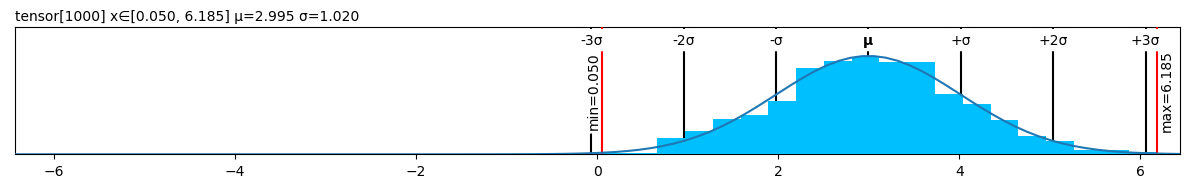

In [ ]:
plot(torch.randn(1000)+3)

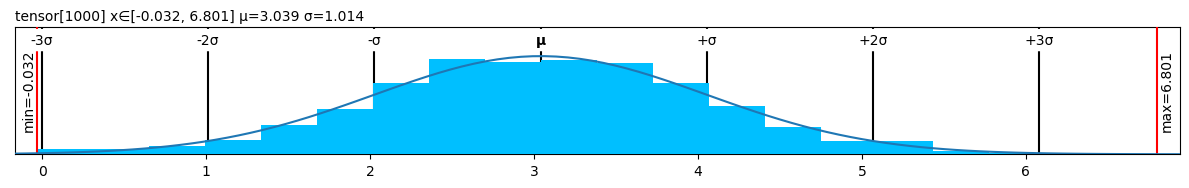

In [ ]:
plot(torch.randn(1000)+3, center="range")

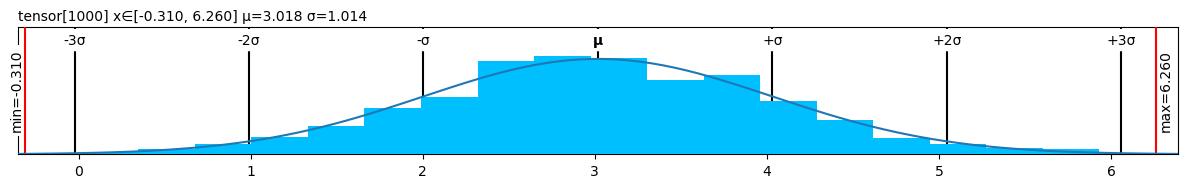

In [ ]:
plot(torch.randn(1000)+3, center="mean")

<AxesSubplot: >

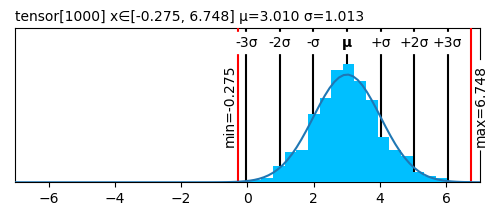

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
plot(torch.randn(1000)+3, ax=ax)

In [ ]:
import gc

before allocation: torch.cuda.memory_allocated()=0
after allocation: torch.cuda.memory_allocated()=1073741824


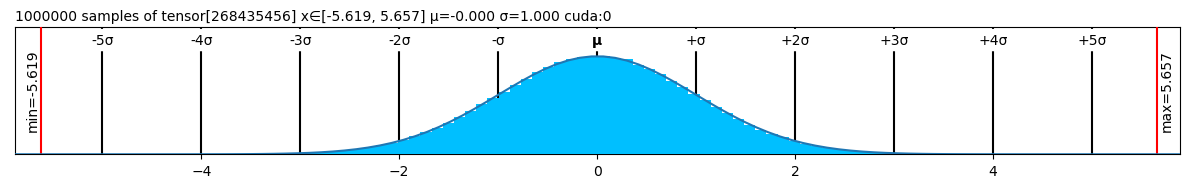

after plot: torch.cuda.memory_allocated()=1073741824
after cleanup: torch.cuda.memory_allocated()=0


In [ ]:
if torch.cuda.is_available():
    cudamem = torch.cuda.memory_allocated()
    print(f"before allocation: {torch.cuda.memory_allocated()=}")
    numbers = torch.randn(1024*1024*256, device="cuda") # 1Gb of numbers
    torch.cuda.synchronize()
    print(f"after allocation: {torch.cuda.memory_allocated()=}")
    display(plot(numbers, max_s=1000000)) # <5 seconds on my system (2080ti, i5). Decent.
    print(f"after plot: {torch.cuda.memory_allocated()=}")
    
    del numbers
    gc.collect()
    torch.cuda.memory.empty_cache()

    print(f"after cleanup: {torch.cuda.memory_allocated()=}")
    assert (cudamem >= torch.cuda.memory_allocated())

In [ ]:
print(f"before allocation: {torch.cuda.memory_allocated()=}")


before allocation: torch.cuda.memory_allocated()=0


In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()